In [7]:
import matplotlib.pyplot as plt
from keras.models import load_model
from numpy.random import randint
import cv2
import imageio
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from os import listdir
from numpy import asarray, load
import os

model = load_model('/data/home/vvaibhav/AI/Internship/Notebook/cGANsSpeechEnhancement/saved_model/model_009649.h5')

def plot_images(src_image, gen_image, tar_image, filename, save_path):
    """
    Plot source, generated, and target images.
    |
    Parameters:
        src_image: Source image.
        gen_image: Generated image.
        tar_image: Target image.
        save_path: Path to save the plot.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot source image
    axs[0].imshow(src_image.squeeze(), cmap='gray')
    axs[0].set_title('Source Image')
    axs[0].axis('off')
    
    # Plot generated image
    axs[1].imshow(gen_image.squeeze(), cmap='gray')
    axs[1].set_title('Generated Image')
    axs[1].axis('off')
    
    # Plot target image
    axs[2].imshow(tar_image.squeeze(), cmap='gray')
    axs[2].set_title('Target Image')
    axs[2].axis('off')
    
    # Save the plot
    plt.savefig(os.path.join(save_path, f'plot_{filename}.png'))
    #plt.savefig(save_path)
    plt.show()

2024-02-13 15:19:15.452933: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 15:19:15.500010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 15:19:15.500051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 15:19:15.501566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 15:19:15.509028: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 15:19:15.509679: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [8]:

def load_images(path, size=(256,512)):
    noisy_src_list, gt_tar_list, filenames = list(), list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        file_path = os.path.join(path, filename)
        pixels = load_img(file_path, target_size=size)

        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        noisy_img, ground_truth_img = pixels[:, 256:], pixels[:, :256]
        noisy_src_list.append(noisy_img)
        gt_tar_list.append(ground_truth_img)
        filenames.append(filename)
        
    return [asarray(noisy_src_list), asarray(gt_tar_list), filenames]


In [9]:

# dataset path
path = '/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/MergedSpectograms/SNR_5dB_-15dB/test'
# load dataset
[noisy_src_images, gt_tar_images, filenames] = load_images(path)
print('Loaded: ', noisy_src_images.shape, gt_tar_images.shape)

# Save only the first image with its original filename
# imageio.imwrite(f'noisy_image_{filenames[0]}.png', noisy_src_images[0].astype('uint8'))
# imageio.imwrite(f'groung_truth_image_{filenames[0]}.png', gt_tar_images[0].astype('uint8'))

data = [noisy_src_images, gt_tar_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)


Loaded:  (3216, 256, 256, 3) (3216, 256, 256, 3)


# Generated Spectogram

1/1 [==============================] - 1s 597ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


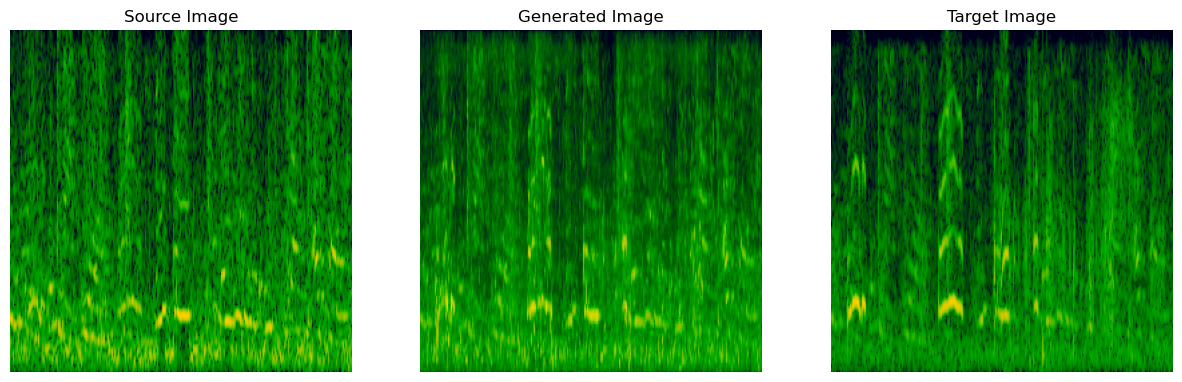

In [10]:

[X1, X2] = dataset
# select random example
# ix = randint(0, len(X1), 1)
# print(ix)
ix = [0]
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
save_path = "/data/home/vvaibhav/AI/Internship/Notebook/cGANsSpeechEnhancement"

plot_images(src_image, gen_image, tar_image, filenames[ix[0]], save_path)

In [11]:
print(filenames[ix[0]])

5db_-15dB_84796_AV_2_seg_4.png


In [12]:
# Rescale the generated image from range [-1, 1] to [0, 255]
rescaled_gen_image = ((gen_image[0] + 1) * 127.5).astype('uint8')

# Save the rescaled generated image with a specified filename
image_filename = "gen"+filenames[ix[0]]  # Specify the desired filename
imageio.imwrite(os.path.join(save_path, image_filename), rescaled_gen_image)


# Spectogram to audio

In [13]:
sample_rate = 4000
window_size = int(32e-3 * sample_rate)  # 32 ms window size
hop_size = int(16e-3 * sample_rate)     # 16 ms hop size
fft_size = 512

In [14]:
# import librosa
# import numpy as np
# import soundfile as sf
# # Compute the complex spectrogram of the noisy input
# # noisy_stft = librosa.stft(noisy_signal, n_fft=fft_size, hop_length=hop_size, win_length=window_size)
# # print(noisy_stft.shape)

# path = "/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/noisy5sec/SNR_-15db(BackgroundNoise)/Spectogram/-15dB_84796_AV_2_seg_4.png"
# noisy_stft = load_img(path)
# noisy_stft = img_to_array(noisy_stft)

# noisy_stft_normalized = noisy_stft.astype(float)
# noisy_stft_normalized /= 255.0
# # # Shift the range from [0, 1] to [-1, 1]
# # noisy_stft_normalized = noisy_stft_normalized * 2.0 - 1.0

# # rescaled_gen_image = gen_image[0] + 1.0
# # # Scale the range from [0, 2] to [0, 255]
# # rescaled_gen_image *= 127.5

# # Shift the range from [-1, 1] to [0, 2]
# rescaled_gen_image = gen_image[0] + 1

# # Scale the values to the range [0, 1]
# rescaled_gen_image /= 2.0


# print(noisy_stft.shape, rescaled_gen_image)

# # Create the complex spectrogram of the generated signal using magnitude of generated spectrogram and phase of noisy input
# gen_stft = np.abs(rescaled_gen_image) * np.exp(1j * np.angle(noisy_stft_normalized))

# # Reconstruct the time-domain signal using inverse STFT
# reconstructed_signal = librosa.istft(gen_stft, hop_length=hop_size, win_length=window_size, n_fft=fft_size)

# # Save the reconstructed signal to a file
# reconstructed_filename = filenames[ix[0]].split('.')[0] + "_reconstructed_signal.wav"
# #librosa.output.write_wav(os.path.join(save_path, reconstructed_filename), reconstructed_signal, sr=4000)
# sf.write(os.path.join(save_path, reconstructed_filename), reconstructed_signal, samplerate=sample_rate)



In [15]:
import librosa
import numpy as np
import soundfile as sf
# Compute the complex spectrogram of the noisy input
# noisy_stft = librosa.stft(noisy_signal, n_fft=fft_size, hop_length=hop_size, win_length=window_size)
# print(noisy_stft.shape)

# Shift the range from [-1, 1] to [0, 2]
rescaled_gen_image = gen_image[0] + 1
# Scale the values to the range [0, 1]
rescaled_gen_image /= 2.0

path = "/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/noisy5sec/SNR_-15db(BackgroundNoise)/Spectogram/-15dB_84796_AV_2_seg_4.png"
audio_length_samples = sample_rate * 5 

# Load the noisy spectrogram and normalize
noisy_stft = load_img(path)
noisy_stft = img_to_array(noisy_stft)
noisy_stft_normalized = noisy_stft.astype(float) / 255.0
print(noisy_stft_normalized.shape)

# Convert the noisy spectrogram to complex format
noisy_stft_complex = noisy_stft_normalized[..., 0] + 1j * noisy_stft_normalized[..., 1]
#print(noisy_stft_complex.shape, rescaled_gen_image.shape)

# Compute the average magnitude across all channels of rescaled_gen_image
average_magnitude = np.mean(rescaled_gen_image, axis=-1)

# Create the complex spectrogram of the generated signal using average magnitude and phase of noisy input
gen_stft_complex = average_magnitude * np.exp(1j * np.angle(noisy_stft_complex))

# Create the complex spectrogram of the generated signal using magnitude of generated spectrogram and phase of noisy input
# gen_stft_complex = np.abs(rescaled_gen_image) * np.exp(1j * np.angle(noisy_stft_normalized))

# Reconstruct the time-domain signal using inverse STFT
reconstructed_signal = librosa.istft(gen_stft_complex, hop_length=hop_size, win_length=window_size, length=audio_length_samples)

# Save the reconstructed signal to a file
reconstructed_filename = filenames[ix[0]].split('.')[0] + "_reconstructed_signal.wav"
sf.write(os.path.join(save_path, reconstructed_filename), reconstructed_signal, samplerate=sample_rate)


(256, 256, 3)


# making the spectogram of generated audio

In [16]:
def make_spectrogram_store1(sample_rate, window_size, hop_size, fft_size, output_folder, audio_files):

    for audio_file in tqdm(audio_files, desc="Processing audio files"): 
        # Load audio file
        sample_rate, audio_data = wavfile.read(audio_file)

        # Compute the spectrogram
        frequencies, times, Sxx = spectrogram(audio_data, fs=sample_rate, window='hamming', nperseg=window_size, noverlap=hop_size, nfft=fft_size)

        
        plt.figure(figsize=(256 / 100, 256 / 100))  # Convert to inches

        # Plot the spectrogram without axis labels and colorbar
        plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
        plt.axis('off')  # Turn off axis labels
        plt.gca().set_axis_off()  # Remove axis labels
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)  # Remove padding
        plt.margins(0, 0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Remove x-axis ticks
        plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Remove y-axis ticks

        # Save the spectrogram as an image in the specified output folder
        filename = os.path.basename(audio_file)  # Get the filename
        image_filename = os.path.join(output_folder, os.path.splitext(filename)[0] + '.png')  # Create full path for image
        plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)  # To remove extra white space
        plt.close()  # Close the figure to release memory

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.io import wavfile
from tqdm import tqdm

# Signal properties
sample_rate = 4000
window_size = int(32e-3 * sample_rate)  # 32 ms window size
hop_size = int(16e-3 * sample_rate)     # 16 ms hop size
fft_size = 512
output_folder = '/data/home/vvaibhav/AI/Internship/Notebook/cGANsSpeechEnhancement'
root_directory = "/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/ground_truth5sec/SNR_5db(BackgroundNoise)"

audio_files = ['/data/home/vvaibhav/AI/Internship/Notebook/cGANsSpeechEnhancement/5db_-15dB_84796_AV_2_seg_4_reconstructed_signal.wav']
make_spectrogram_store1(sample_rate, window_size, hop_size, fft_size, output_folder, audio_files)

Processing audio files:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_2828345/1369200831.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
Processing audio files: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


# code given by alex

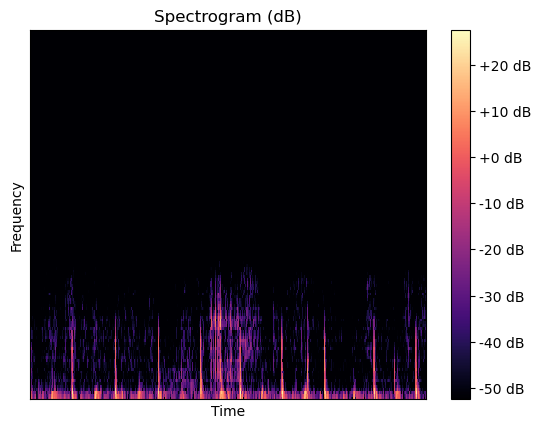

In [5]:

import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

my_sample_rate = 44100
# step1 - converting a wav file to numpy array and then converting that to mel-spectrogram
my_audio_as_np_array, my_sample_rate= librosa.load("/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/original_audio5Sec/2530_AV_1.wav", sr = my_sample_rate)

# step2 - converting audio np array to spectrogram
spec = librosa.feature.melspectrogram(y=my_audio_as_np_array,
                                        sr=my_sample_rate,
                                            n_fft=1024,
                                            hop_length=512,
                                            win_length=None,
                                            window='hann',
                                            center=True,
                                            pad_mode='reflect',
                                            power=2.0)
                                            #n_mels=128)

spectrogram = np.abs(spec)
#X_inv = librosa.griffinlim(np.abs(stft_lib))
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=my_sample_rate,hop_length=512)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.savefig("spectogram_log.png")
plt.show()

# step3 converting mel-spectrogrma back to wav file

res = librosa.feature.inverse.mel_to_audio(spec,
                                           sr=my_sample_rate,
                                           n_fft=1024,
                                           hop_length=512,
                                           win_length=None,
                                           window='hann',
                                           center=True,
                                           pad_mode='reflect',
                                           power=2.0,
                                           n_iter=32)
                                           #n_mels=128)

# step4 - save it as a wav file
import soundfile as sf
sf.write("test2.wav", res, my_sample_rate)


In [ ]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

my_sample_rate = 44100

# Step 1: Load audio
my_audio_as_np_array, my_sample_rate = librosa.load(
    "/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/original_audio5Sec/2530_AV_1.wav",
    sr=my_sample_rate,
)

# Step 2: Calculate spectrogram
spec = librosa.stft(
    y=my_audio_as_np_array,
    n_fft=1024,
    hop_length=512,
    win_length=None,
    window="hann",
    center=True,
    pad_mode="reflect",
)

# Step 3: Convert to absolute values and decibels
spectrogram = np.abs(spec)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# Step 4: Display and save spectrogram
librosa.display.specshow(log_spectrogram, sr=my_sample_rate, hop_length=512)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.savefig("spectrogram_log.png")
plt.show()

# Step 5 (optional): Save as WAV file (not recommended)
# Reconstructing audio from STFT is lossy and prone to artifacts. However, if you must:
# res = librosa.griffinlim(spec, n_iter=32)
# sf.write("test2.wav", res, my_sample_rate)



In [ ]:
librosa.istft(gen_stft_complex, hop_length=hop_size, win_length=window_size, length=audio_length_samples)

In [7]:

import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

my_sample_rate = 44100
# step1 - converting a wav file to numpy array and then converting that to mel-spectrogram
my_audio_as_np_array, my_sample_rate= librosa.load("/data/home/vvaibhav/AI/Internship/Dataset/PreparedData/original_audio5Sec/2530_AV_1.wav", sr = my_sample_rate)

# step2 - converting audio np array to spectrogram
spec = librosa.stft(y=my_audio_as_np_array,
                                        sr=my_sample_rate,
                                            n_fft=1024,
                                            hop_length=512,
                                            win_length=None,
                                            window='hann',
                                            center=True,
                                            pad_mode='reflect',
                                            power=2.0)
                                            #n_mels=128)

spectrogram = np.abs(spec)
#X_inv = librosa.griffinlim(np.abs(stft_lib))
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=my_sample_rate,hop_length=512)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.savefig("spectogram_log.png")
plt.show()

# step3 converting mel-spectrogrma back to wav file

res = librosa.istft(spec,
                        sr=my_sample_rate,
                        n_fft=1024,
                        hop_length=512,
                        win_length=None,
                        window='hann',
                        center=True,
                        pad_mode='reflect',
                        power=2.0,
                        n_iter=32)
                        #n_mels=128)

# step4 - save it as a wav file
import soundfile as sf
sf.write("Spec_only_test2.wav", res, my_sample_rate)


TypeError: stft() got an unexpected keyword argument 'sr'